In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000

In [21]:
def show_image(values, index):
    """
    Display image selected by index from gives values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [22]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (69000,)
values_train.shape = (784, 69000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


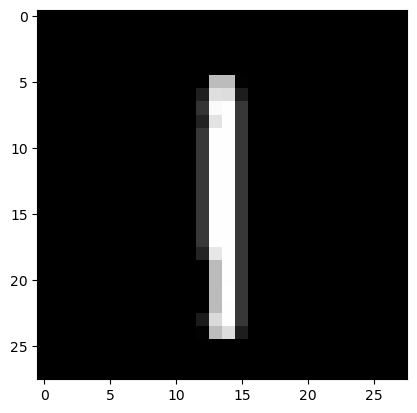

In [23]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[TEST_SIZE:m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [24]:
def init_params():
    """Initialize NN weights and biases"""
    #
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels):
    """Perform one hot encoding returning a binary matrix based on provided labels"""
    # Class 0 -> [1,0,0,...]
    # Class 1 -> [0,1,0,...]
    # ...

    one_hot_labels = np.zeros((labels.size, labels.max() + 1))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels.T

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, 1)

    # calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / m * dZ1.dot(values.T)
    db1 = 1 / m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [25]:
def cross_entropy_loss(A2, labels):
    """
    Calculate cross-entropy loss 
    """
    m = labels.shape[1]
    log_likelihood = -np.log(A2[labels == 1])
    loss = np.sum(log_likelihood) / m
    return loss

In [26]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def gradient_descent(values_train, labels_train, iterations, alpha, values_validation, labels_validation ):
    """Create a 3 layer NN and train it using gradient descent method"""
    W1, b1, W2, b2 = init_params()
    accuracy_history = [0]
    for i in range(iterations):
        
        # NN training 
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, values_train)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, values_train, labels_train)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Training pogress 
        if i % 10 == 0:
            print("Iteration:", i)

            # make predictions and test accuracy using validation set
            predictions = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy = get_accuracy(predictions, labels_validation)
            print("Accuracy: ", accuracy)

            # present traininig progress
            accuracy_history.append(accuracy)
            plt.plot (accuracy_history)
            plt.xlabel('Iterations (x10)')
            plt.ylabel('Accuracy')
            plt.show()

    return W1, b1, W2, b2

Iteration: 0
[2 4 0 3 2 2 3 3 6 2 3 0 5 0 2 2 3 3 2 0 9 3 3 0 3 6 4 0 3 3 3 0 5 2 2 0 3
 2 2 2 0 2 3 3 4 2 3 2 0 6 0 2 2 2 0 3 2 0 3 0 2 3 3 0 8 8 8 0 3 0 3 2 2 0
 6 2 2 0 3 3 2 6 0 2 6 8 6 3 0 2 3 2 3 0 2 3 0 3 3 2 6 2 3 2 3 3 3 4 2 2 3
 2 2 6 0 3 3 3 3 2 6 2 0 0 6 2 0 3 8 3 3 3 0 9 2 0 6 6 2 2 3 0 2 3 3 6 2 2
 0 3 3 6 3 3 2 6 0 2 4 3 0 3 2 0 3 3 3 3 6 2 3 0 2 2 2 0 0 3 2 3 2 3 3 2 8
 2 2 0 0 4 2 8 3 0 0 2 3 4 2 5 3 3 0 2 2 0 6 6 4 5 0 6 3 0 4 2 4 0 3 0 3 0
 2 2 0 0 5 8 3 4 0 9 2 0 6 2 2 2 0 2 2 2 9 0 3 6 3 2 2 2 0 8 6 4 2 2 4 3 8
 0 2 3 3 2 3 0 3 3 3 2 3 2 5 0 0 2 3 0 3 0 8 3 6 4 0 6 3 0 3 8 3 4 0 0 3 3
 2 3 0 3 0 6 3 2 2 2 2 3 5 2 2 2 3 2 3 3 3 3 2 3 3 3 6 4 0 3 3 3 3 3 3 2 3
 3 2 3 2 3 2 0 3 3 3 2 3 3 2 2 0 3 2 0 8 3 3 3 2 3 0 3 3 2 0 0 0 3 3 2 4 2
 2 3 3 3 3 2 3 0 3 0 0 3 7 0 3 3 2 0 3 0 3 3 2 6 3 3 2 0 3 2 3 2 3 0 2 2 2
 2 3 3 3 3 3 2 3 0 0 6 3 3 2 5 0 2 3 0 3 5 3 6 0 2 3 3 2 2 3 2 3 6 5 5 2 6
 2 6 3 2 0 2 3 0 0 3 8 4 0 6 3 0 3 5 3 6 3 8 3 3 2 0 3 0 3 2 2 3 2 2 0 5 2
 4 2 2 3 5 3

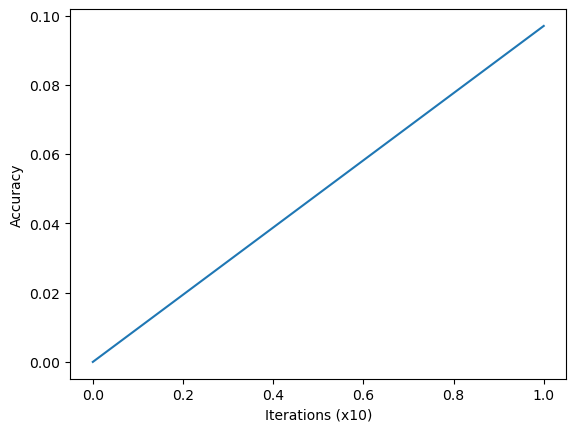

Iteration: 10
[2 4 0 9 4 7 3 4 6 4 4 0 5 6 8 8 3 7 2 7 9 9 6 7 4 8 4 4 7 3 4 4 5 8 5 2 4
 4 8 0 4 2 9 4 4 9 5 4 0 7 4 2 4 4 4 0 8 2 4 5 8 9 4 0 8 8 9 7 4 5 9 2 8 0
 6 0 4 4 6 9 4 7 7 2 6 8 6 6 5 2 9 2 3 4 2 9 0 5 0 2 9 5 5 8 5 9 0 4 2 2 2
 2 5 9 0 4 7 9 0 4 6 4 0 0 7 0 4 4 8 0 4 2 0 9 2 4 6 6 2 2 6 0 4 8 0 6 2 5
 4 3 9 6 0 0 5 7 0 2 4 6 4 5 8 0 4 6 0 9 7 5 5 4 2 5 7 0 6 6 7 5 8 9 4 5 8
 4 4 0 0 4 4 4 5 0 0 2 3 4 8 5 4 4 4 2 2 2 9 6 4 5 9 6 0 4 4 2 4 0 5 4 6 0
 9 2 0 4 5 8 5 4 8 9 2 0 9 4 2 2 7 3 9 4 9 0 9 9 5 2 4 4 0 4 6 4 2 4 4 5 8
 4 2 3 6 9 4 0 3 5 6 4 9 5 5 0 4 7 6 2 3 0 4 4 6 4 3 6 6 5 9 8 4 4 0 4 4 8
 2 6 0 4 2 6 5 4 9 9 4 9 5 5 4 5 9 8 4 9 0 0 4 5 4 5 6 4 0 3 0 9 0 0 3 2 4
 9 5 3 2 4 4 0 4 0 4 2 6 6 4 4 5 4 0 0 4 0 4 3 4 8 9 7 6 4 7 7 0 8 0 5 4 2
 8 6 5 5 0 2 6 0 3 4 4 5 7 0 3 4 4 2 0 0 0 5 7 9 9 9 8 4 6 7 3 2 4 4 8 4 8
 8 9 0 6 9 8 4 4 0 6 9 7 4 9 5 0 7 7 9 6 5 6 9 0 2 3 6 4 5 4 2 5 7 5 5 2 9
 7 9 4 9 7 7 6 5 8 9 8 4 4 7 4 2 4 5 4 9 3 8 6 9 7 4 4 4 5 9 7 5 9 2 2 4 0
 4 4 9 9 5 

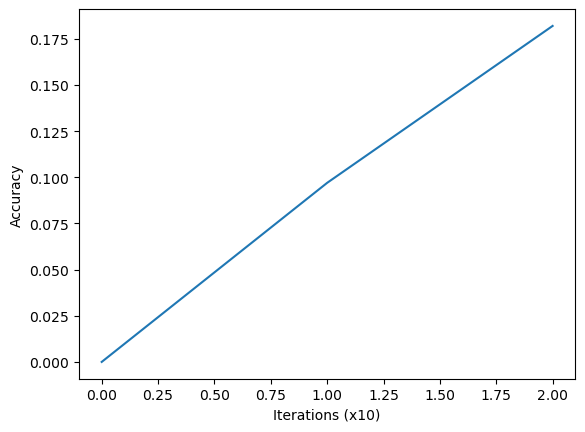

Iteration: 20
[2 4 0 9 4 7 8 2 6 4 4 0 5 6 8 8 3 7 0 7 9 9 6 7 7 8 4 4 7 8 4 4 5 8 5 2 4
 4 8 5 4 4 9 4 4 9 0 4 0 7 4 2 4 7 4 0 8 2 7 5 8 6 4 0 4 2 9 7 4 5 4 3 8 0
 7 7 4 9 6 9 4 7 7 2 9 8 6 6 5 2 9 2 3 7 8 9 9 0 0 4 9 5 5 8 5 9 0 9 8 2 2
 2 5 9 0 7 7 9 0 0 6 8 0 0 7 0 7 0 8 0 9 2 4 9 3 4 9 0 2 7 6 0 4 8 0 6 5 5
 4 4 9 7 0 0 5 7 0 2 4 6 2 5 8 7 4 6 0 9 7 5 5 4 2 5 7 0 6 9 7 5 8 9 4 5 4
 4 4 0 0 4 9 4 4 0 0 7 3 4 0 5 2 4 4 8 8 5 4 9 4 5 9 9 0 4 4 3 4 0 5 4 6 0
 8 2 0 4 5 8 5 4 8 9 5 0 9 4 5 2 7 3 9 4 6 0 9 9 5 8 4 4 0 4 0 4 2 7 4 5 8
 4 2 4 6 9 4 0 9 5 6 4 9 7 5 4 7 7 6 2 3 6 4 4 6 4 3 9 6 5 9 8 4 4 0 4 4 8
 0 6 6 7 2 9 0 4 9 8 4 9 0 5 4 5 9 8 4 9 0 0 4 5 4 5 6 4 0 9 0 9 0 0 4 2 0
 9 5 3 3 4 4 0 4 0 7 2 0 6 4 4 5 4 0 0 4 0 4 3 4 8 9 7 6 4 7 7 0 8 0 5 4 2
 8 0 5 4 0 2 6 0 3 4 4 5 7 8 7 4 4 2 0 0 0 5 7 9 9 9 8 4 6 7 3 2 4 7 8 8 8
 8 9 0 6 9 8 4 0 0 6 9 7 4 8 5 0 7 7 9 6 7 6 9 0 2 3 6 4 5 4 2 5 7 5 5 5 9
 7 9 7 8 7 7 6 0 8 9 8 4 9 7 4 2 4 5 0 9 6 8 6 9 7 4 4 4 5 8 7 5 8 5 2 4 7
 4 4 8 9 5 

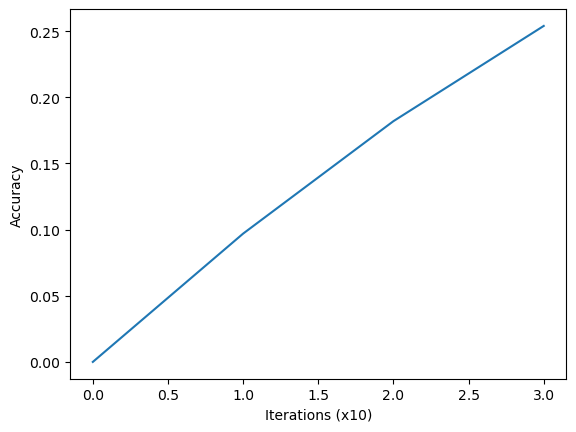

Iteration: 30
[2 4 0 9 4 7 8 2 6 2 4 0 5 6 2 8 5 7 3 7 9 9 0 7 7 8 4 4 7 8 9 4 7 8 5 8 4
 4 2 5 4 4 9 4 4 9 0 4 6 7 4 8 4 7 4 0 8 2 7 5 8 6 4 0 4 2 9 7 4 5 4 0 2 0
 7 7 4 9 6 9 4 7 7 8 9 8 6 6 5 2 9 3 8 7 8 9 9 0 0 8 8 5 5 8 5 6 0 9 8 2 2
 3 5 9 0 7 7 9 0 0 6 8 0 9 7 0 7 0 8 0 9 2 4 9 3 4 9 0 8 8 6 0 4 0 6 9 5 5
 4 3 6 7 0 0 5 7 0 4 4 6 2 0 8 7 4 6 0 8 7 5 3 4 8 5 7 0 6 9 7 0 8 9 4 5 4
 2 4 0 5 4 9 4 7 0 0 2 6 4 0 5 2 4 4 8 8 5 9 9 4 5 8 9 0 4 4 3 4 0 5 4 6 0
 8 2 0 7 0 8 5 4 8 9 5 0 9 4 5 5 7 3 8 4 6 2 6 9 5 8 4 8 0 4 0 4 2 7 4 6 8
 4 2 4 0 9 4 0 4 5 0 4 9 7 5 4 7 7 6 9 4 6 4 4 6 4 3 9 6 5 9 2 4 4 0 4 4 8
 8 6 6 7 2 9 0 2 8 8 4 9 0 5 4 5 9 2 4 9 0 6 4 0 7 5 6 4 0 9 6 9 0 0 6 3 0
 6 5 4 3 4 4 0 4 6 7 2 0 6 4 4 5 4 0 0 4 0 9 3 4 8 9 7 6 2 7 7 2 8 0 5 4 8
 2 0 5 4 0 8 0 0 8 4 4 5 7 8 7 4 4 2 0 0 0 3 7 9 9 9 8 4 9 7 3 8 4 7 2 8 8
 2 9 0 6 9 8 4 0 0 6 9 7 4 8 4 0 3 7 6 6 7 6 9 7 2 3 0 4 5 4 2 5 7 5 5 3 9
 7 9 7 8 7 7 6 0 8 9 8 7 9 7 4 8 9 5 0 9 9 8 6 9 7 4 4 4 3 8 7 5 8 5 2 5 7
 4 4 8 8 5 

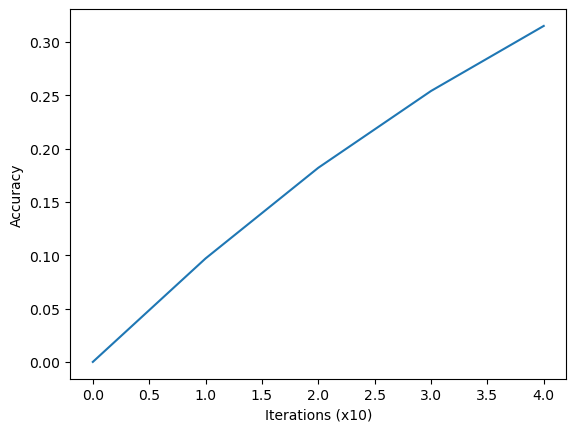

Iteration: 40
[2 4 0 9 8 7 8 2 6 2 4 0 0 6 2 8 5 7 3 7 9 9 9 7 7 8 4 5 7 3 7 3 7 8 5 8 4
 4 2 5 2 8 9 4 4 9 0 1 6 7 0 8 4 7 4 0 8 2 7 8 8 6 4 0 4 2 9 7 4 5 3 0 2 6
 7 7 4 9 6 8 4 7 7 8 9 2 6 6 5 3 9 3 8 7 8 9 9 0 0 8 8 5 5 8 5 6 0 9 8 2 2
 3 8 9 0 7 7 9 0 0 6 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 3 8 6 6 2 2 6 9 5 3
 2 3 9 7 0 0 5 7 0 4 4 6 2 0 8 9 4 6 0 8 7 5 3 4 8 5 7 2 6 9 7 0 8 9 4 5 4
 2 2 0 5 4 7 9 7 0 0 2 6 4 0 5 2 4 9 8 8 5 9 9 4 3 8 9 2 6 1 3 4 0 5 4 6 0
 8 2 0 7 0 8 5 4 8 8 5 0 9 4 5 5 7 3 8 4 6 2 6 9 5 8 1 8 0 4 0 4 2 7 4 6 2
 9 2 4 0 9 4 0 4 5 0 8 9 7 5 4 0 3 6 9 3 6 2 4 7 4 3 9 6 5 9 2 3 4 0 4 4 4
 8 6 6 7 2 9 0 2 8 8 4 9 0 3 4 5 9 2 4 9 0 6 4 0 7 0 6 4 0 9 6 9 0 0 6 3 6
 6 3 4 3 4 4 0 4 6 7 2 0 6 8 8 5 4 8 6 4 0 9 3 4 8 9 7 6 2 7 7 2 2 0 5 4 8
 2 0 8 4 0 8 0 6 9 8 4 5 7 8 7 1 2 2 0 0 3 3 7 9 9 8 2 4 9 7 3 8 4 7 2 3 2
 2 9 0 6 9 8 3 0 0 6 9 7 2 8 4 7 3 7 6 6 7 6 9 7 2 3 0 4 5 4 2 0 7 5 5 3 9
 5 9 7 8 7 7 6 0 9 9 8 7 9 7 4 8 8 5 0 9 9 2 6 6 9 4 4 0 3 8 7 5 8 7 2 5 7
 4 8 8 8 5 

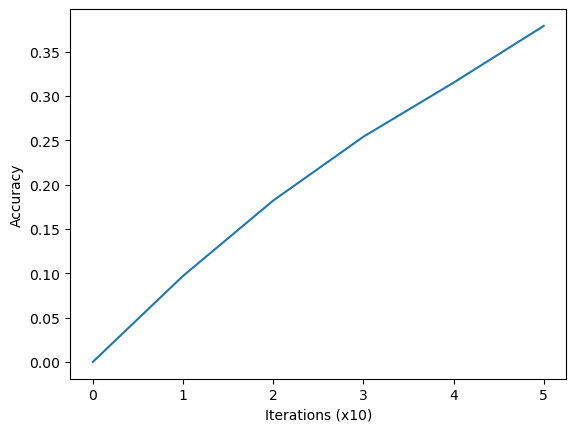

Iteration: 50
[2 9 0 9 8 3 8 2 6 2 4 0 0 6 2 8 5 7 3 7 8 9 9 9 7 8 4 5 7 2 7 3 7 8 5 8 1
 4 2 5 2 8 9 4 4 9 0 1 6 7 0 8 8 7 4 4 8 2 7 8 8 6 4 0 4 2 7 7 4 5 3 0 2 6
 7 7 4 9 6 8 1 7 7 8 6 2 6 6 5 3 9 3 8 7 8 9 9 0 0 8 8 5 5 8 3 6 0 9 8 2 2
 3 8 9 0 7 7 9 6 0 9 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 3 8 6 6 2 2 6 9 5 3
 2 3 9 7 0 0 5 7 0 4 4 6 2 0 8 9 4 6 0 8 7 5 3 4 8 5 7 2 6 9 7 6 2 9 1 5 4
 2 2 4 5 1 7 1 7 0 0 2 6 4 3 5 2 4 9 8 8 8 8 9 4 3 8 9 2 6 1 3 4 0 5 7 6 0
 1 2 0 7 0 8 5 1 8 8 5 6 9 4 5 5 7 3 8 8 6 2 6 9 5 8 1 8 0 4 6 4 2 7 4 6 2
 1 2 4 0 9 4 0 8 9 0 8 9 7 5 4 0 3 6 9 3 6 2 1 9 4 3 9 6 5 9 2 3 4 0 2 4 4
 8 6 6 7 2 9 0 8 8 8 4 9 0 3 8 5 9 2 9 9 0 6 4 0 7 0 1 4 0 9 6 9 0 0 6 3 6
 6 3 4 3 4 9 0 4 6 7 2 0 6 8 8 8 9 8 6 4 0 9 7 4 8 9 0 6 8 7 0 2 2 0 5 4 8
 2 0 8 4 0 8 0 6 1 8 1 5 7 8 7 1 2 2 0 0 3 3 5 9 1 8 2 4 9 9 3 9 3 7 2 3 2
 2 9 0 6 9 4 3 0 0 6 9 7 2 8 4 7 3 7 6 6 7 6 0 7 2 3 0 4 5 1 2 0 7 5 5 3 9
 3 9 7 8 7 9 6 0 9 9 8 7 9 7 2 8 8 5 0 8 9 2 6 6 9 4 4 0 3 8 7 5 8 7 2 5 9
 4 8 8 8 5 

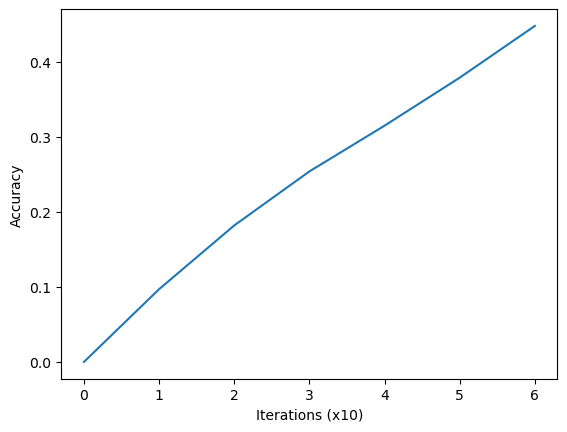

Iteration: 60
[2 9 0 9 8 3 8 2 5 2 3 0 0 6 2 8 5 7 3 7 8 9 9 9 7 1 8 5 7 2 7 3 7 8 5 8 1
 4 2 5 2 8 8 9 4 9 0 1 6 7 0 8 8 3 4 4 8 2 7 8 8 6 4 0 4 2 7 7 9 5 3 0 2 6
 9 7 4 9 6 9 1 7 7 8 0 2 6 0 5 3 1 3 8 7 8 9 9 0 0 1 8 5 5 2 3 6 0 9 8 2 2
 3 8 8 0 7 7 6 6 0 9 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 3 8 6 6 2 2 6 9 5 3
 8 3 9 7 0 0 5 7 0 4 4 6 8 0 8 9 1 6 0 8 7 5 3 4 8 5 7 2 6 2 9 6 2 9 1 5 4
 2 2 4 5 1 7 1 7 0 0 2 6 8 2 5 2 4 9 8 9 9 8 9 4 3 8 9 2 6 1 3 4 5 5 7 6 0
 1 2 0 7 0 8 5 1 8 8 5 6 9 4 5 3 7 3 8 8 6 2 6 9 3 8 1 8 2 4 6 1 2 3 4 6 2
 1 2 4 0 9 4 0 8 9 0 8 8 4 5 9 0 3 6 1 3 6 2 1 9 1 3 9 6 5 9 2 3 4 4 2 4 4
 8 6 6 7 2 9 0 8 5 8 4 9 0 3 8 5 9 2 9 8 0 6 4 0 7 0 1 4 5 9 6 9 0 4 2 3 6
 6 3 4 3 4 9 0 2 6 7 2 0 6 8 8 8 9 8 6 4 0 9 7 1 8 9 0 6 8 6 0 2 2 0 8 4 2
 2 0 8 4 0 8 0 6 1 8 1 5 7 8 7 1 2 2 0 6 3 3 5 9 1 8 2 8 9 1 3 9 3 7 2 3 2
 2 8 6 6 9 4 3 0 0 6 8 7 2 8 4 7 3 7 6 6 7 6 0 7 2 3 0 4 5 1 3 0 7 5 3 3 9
 3 9 7 8 7 9 6 0 9 9 2 7 9 7 2 8 8 5 0 8 9 2 6 6 9 4 3 0 7 8 7 5 8 7 2 3 9
 9 8 8 8 5 

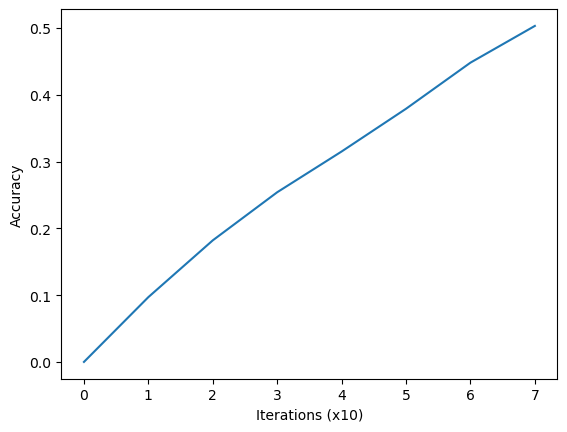

Iteration: 70
[2 9 0 9 8 3 8 2 5 2 8 0 0 6 2 8 5 7 3 7 8 1 9 9 7 1 8 5 7 2 7 3 7 8 5 8 1
 4 2 5 2 8 8 1 4 9 0 1 6 7 0 8 8 3 4 4 8 2 7 8 8 6 1 0 4 2 7 7 9 5 3 0 2 6
 9 7 9 9 6 9 1 7 7 8 0 2 6 0 5 3 1 3 8 7 8 9 9 0 0 1 8 5 5 2 0 6 0 9 8 2 2
 3 8 8 0 7 7 6 6 0 9 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 3 8 6 6 2 2 6 9 5 3
 1 3 9 9 0 0 3 5 6 4 4 6 8 0 8 1 1 6 4 8 7 5 3 4 8 5 7 2 6 2 9 6 2 1 1 5 4
 1 2 4 5 1 7 1 7 0 0 2 6 8 2 5 2 4 9 8 9 9 8 9 2 3 8 9 2 2 1 3 4 5 5 7 6 4
 1 2 0 7 0 8 8 1 8 8 3 6 9 4 5 3 7 3 8 8 6 2 8 9 3 1 1 8 2 4 6 1 2 3 4 6 2
 1 2 4 0 9 4 0 8 9 0 8 8 4 5 9 0 3 6 1 2 6 2 1 9 1 3 9 6 5 6 2 3 4 4 2 4 4
 8 6 6 7 2 9 0 1 5 8 4 9 0 3 8 5 8 2 9 8 0 6 4 0 7 0 1 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 4 9 0 2 6 7 2 0 6 8 8 8 9 8 6 4 0 9 7 1 8 9 0 6 8 6 0 2 2 0 8 4 2
 2 0 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 3 3 5 9 1 8 2 8 9 1 3 9 3 7 2 3 2
 2 8 6 6 3 4 3 0 0 6 5 7 2 8 4 7 3 7 6 6 7 6 5 7 2 3 0 4 5 1 3 0 7 5 3 3 9
 3 1 7 8 7 9 6 0 9 9 2 3 7 7 2 8 1 3 0 8 9 2 6 6 9 4 3 0 9 8 7 5 8 7 2 3 9
 9 8 8 8 5 

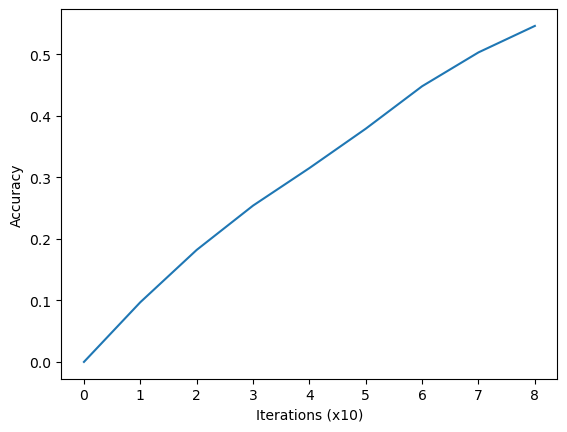

Iteration: 80
[2 1 0 9 8 3 8 2 5 8 8 0 0 6 2 8 5 9 3 7 8 1 9 9 7 1 8 5 7 2 7 3 7 8 5 1 1
 4 2 5 2 8 1 1 4 9 0 1 6 7 0 8 8 3 4 4 8 2 7 8 8 6 1 0 4 2 7 7 9 5 3 0 2 6
 9 7 9 9 6 9 1 7 7 8 0 2 6 2 5 3 1 3 8 7 8 1 9 0 0 1 1 5 5 2 0 2 0 9 4 2 2
 3 9 1 0 7 7 6 6 0 9 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 5 5 6 6 2 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 8 0 8 1 1 6 4 8 7 3 3 4 8 5 9 2 6 2 9 6 2 1 1 5 4
 1 2 4 5 1 7 1 7 0 6 8 6 8 2 5 2 2 9 8 1 4 8 9 2 3 8 9 2 2 1 3 4 5 5 7 6 4
 9 2 0 7 0 8 8 1 8 1 3 6 9 4 3 3 7 3 8 1 6 2 8 9 3 1 1 8 2 4 6 1 2 3 4 6 2
 1 2 4 0 9 4 0 8 9 0 8 8 4 5 9 0 3 6 1 2 6 2 1 9 1 3 9 6 5 6 2 3 4 4 2 4 4
 8 6 6 9 2 9 0 1 5 8 4 9 0 3 8 5 8 2 9 8 0 6 3 0 7 0 1 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 9 2 2 6 7 2 0 6 8 8 8 9 8 6 4 0 9 7 1 8 9 0 6 8 6 0 2 2 0 8 4 2
 2 0 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 3 3 5 9 1 8 2 8 1 1 3 9 3 7 2 3 2
 2 1 6 6 3 2 3 0 0 6 5 7 2 8 4 7 3 7 6 6 7 6 5 7 2 2 0 4 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 9 6 0 9 9 2 3 7 9 2 8 1 3 0 8 1 2 6 6 9 4 3 0 9 8 7 5 8 7 8 3 9
 9 8 8 8 5 

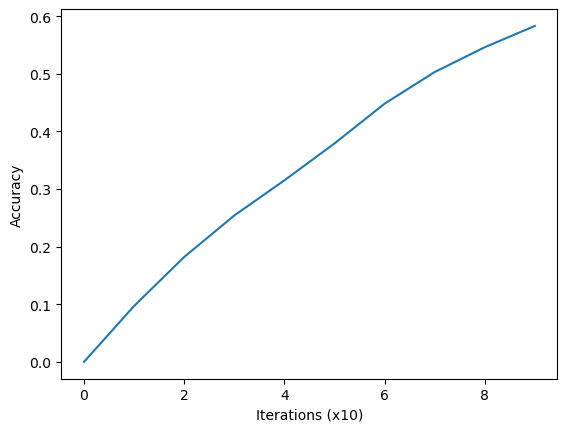

Iteration: 90
[2 1 0 9 8 3 8 2 5 1 1 0 0 6 2 8 5 9 3 7 1 1 9 9 7 1 8 5 7 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 7 0 8 8 3 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 9 9 6 9 1 9 7 8 0 2 6 2 5 3 1 3 8 7 8 1 9 0 0 1 1 5 5 2 0 2 0 9 4 2 2
 3 9 1 0 7 7 6 6 0 9 8 0 9 5 3 4 0 2 6 9 2 8 7 3 4 9 0 5 5 6 6 2 2 6 7 5 3
 1 3 1 9 0 0 3 5 6 4 8 6 8 7 8 1 1 6 4 8 7 3 3 4 8 5 9 2 6 2 9 6 2 1 1 3 4
 1 2 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 9 8 1 4 8 9 2 2 8 9 2 2 1 3 4 5 5 7 6 4
 9 2 0 7 0 9 8 1 8 1 3 6 9 4 3 3 7 3 8 1 6 2 8 9 3 1 1 8 2 4 6 1 2 3 4 6 2
 1 5 4 0 9 4 0 8 9 0 8 8 9 5 9 0 3 6 1 2 6 2 1 9 1 3 5 6 5 6 2 3 4 4 0 9 4
 8 6 6 9 2 9 0 1 5 8 4 9 0 3 3 5 8 2 9 8 0 6 3 0 7 0 1 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 9 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 9 7 1 8 9 0 6 8 6 0 2 2 0 8 4 2
 2 0 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 3 3 5 9 1 8 2 8 1 1 3 9 3 7 4 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 4 7 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 9 6 0 7 9 2 3 7 9 2 8 1 3 0 8 1 2 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 9 8 1 8 5 

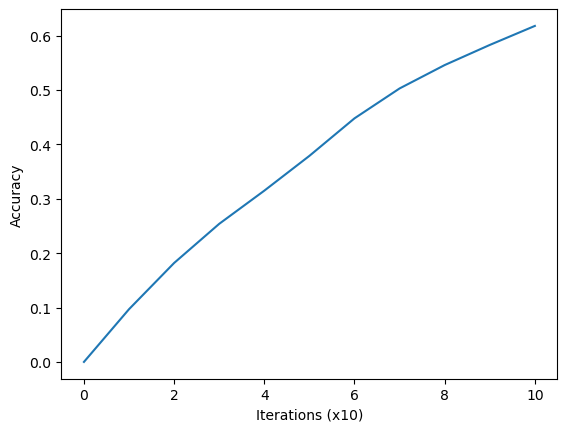

Iteration: 100
[2 1 0 9 8 3 8 2 5 1 1 0 0 6 2 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 8 3 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 9 9 6 9 1 9 7 8 0 2 6 2 5 3 1 3 8 7 8 9 9 0 0 1 1 5 5 2 7 2 0 1 4 2 2
 3 4 1 2 7 7 6 6 0 9 3 0 9 5 3 4 0 2 6 9 2 8 7 3 0 9 0 5 5 6 7 2 2 6 7 5 3
 1 3 1 9 0 0 3 5 6 4 8 6 8 7 8 1 1 6 4 8 7 3 3 4 8 5 9 2 6 2 9 6 2 1 1 3 4
 1 2 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 9 8 1 4 8 9 2 2 8 9 2 2 1 3 4 5 5 7 6 4
 9 2 0 9 0 4 8 1 8 1 3 6 9 4 3 3 7 3 8 1 6 2 8 9 3 1 1 8 2 4 6 1 2 3 4 6 2
 1 5 4 0 9 4 0 8 9 0 1 8 9 5 9 0 3 6 7 2 6 2 1 9 1 3 5 6 5 6 2 3 4 4 0 9 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 8 2 9 8 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 9 7 1 1 8 0 6 8 6 0 2 2 0 8 4 2
 2 0 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 1 3 9 3 7 9 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 7 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 2 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 9 8 1 1 5

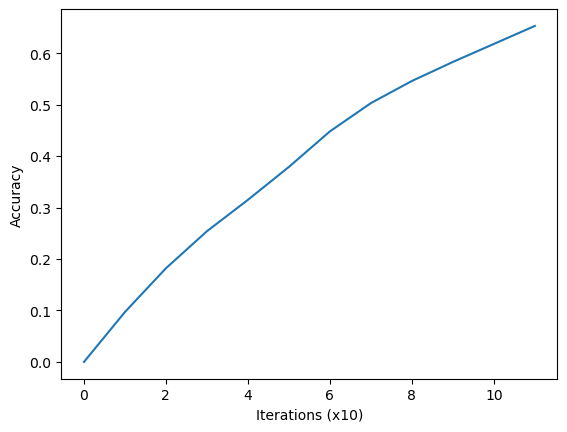

Iteration: 110
[2 1 0 9 8 3 8 2 5 1 1 0 0 6 2 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 8 3 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 9 9 6 9 1 9 7 8 0 2 6 2 5 3 1 3 8 7 8 9 9 0 0 1 9 5 5 2 7 2 0 1 4 2 2
 3 4 1 2 7 7 6 6 0 8 3 0 9 5 3 4 0 2 6 9 2 8 7 3 0 9 0 5 5 6 7 2 2 6 7 5 3
 1 3 1 9 0 0 3 5 6 4 8 6 8 7 8 1 1 6 4 8 7 3 3 4 8 5 9 2 6 2 9 6 2 1 1 3 4
 1 1 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 4 8 9 4 8 9 2 2 8 9 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 8 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 8 2 4 6 1 5 3 4 6 3
 1 5 4 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 6 2 3 4 4 0 9 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 8 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 9 7 1 1 8 0 6 8 6 0 2 2 0 8 4 2
 2 7 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 7 3 7 6 6 7 6 5 3 2 2 0 8 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 8 8 1 1 5

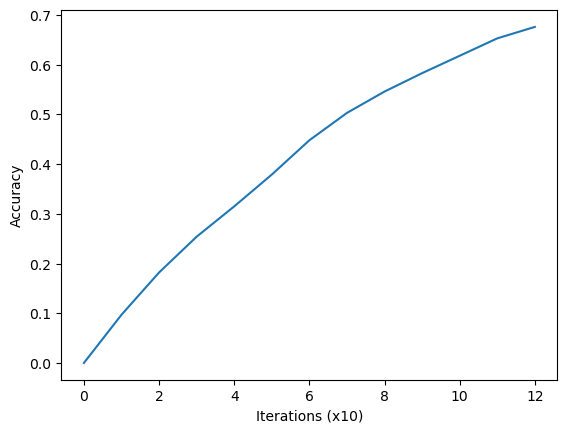

Iteration: 120
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 2 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 3 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 9 1 9 7 8 0 2 6 2 5 3 1 3 8 7 8 9 9 0 0 1 9 3 5 2 7 2 0 1 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 9 5 3 4 0 2 6 9 2 8 7 3 0 4 0 5 5 6 7 2 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 3 3 4 8 5 9 2 6 2 9 6 2 1 1 3 4
 1 1 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 4 8 9 4 8 9 2 2 8 9 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 8 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 6 1 5 3 4 6 3
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 0 9 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 8 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 9 7 1 1 8 0 6 8 6 0 2 2 0 8 4 2
 2 7 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 7 3 7 6 6 7 6 5 3 2 2 0 8 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 8 1 1 1 5

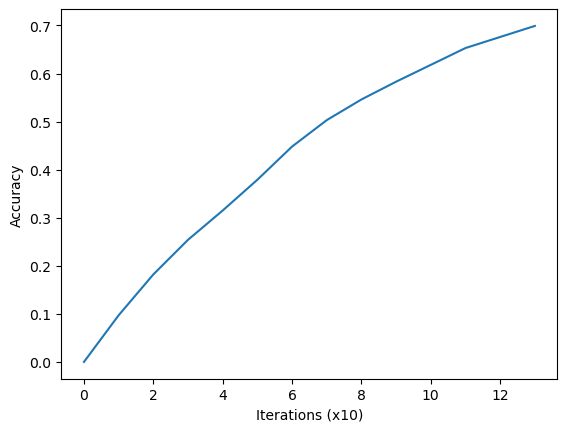

Iteration: 130
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 3 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 9 1 9 7 8 0 2 6 2 5 3 1 3 8 7 8 9 9 2 0 1 9 3 5 2 7 2 0 1 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 9 5 3 4 0 2 6 9 2 8 7 3 0 2 0 5 5 6 7 2 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 3 3 4 1 5 9 2 6 2 9 6 2 1 1 3 4
 1 1 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 4 8 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 8 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 6 1 5 3 4 6 3
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 0 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 8 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 8 7 1 1 8 0 6 8 6 0 2 2 0 8 4 2
 2 7 8 4 0 8 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 7 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 1
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 8 1 1 1 5

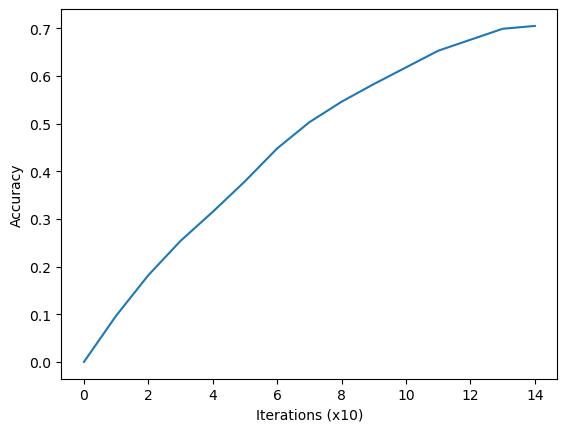

Iteration: 140
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 6 1 4 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 7 8 9 9 2 0 1 9 3 5 2 7 2 0 1 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 2 6 9 2 8 7 3 0 2 0 5 5 6 7 2 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 9 2 6 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 1 7 0 6 8 6 8 0 5 2 2 4 8 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 8 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 6 1 5 3 4 6 3
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 8 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 8 7 1 1 8 0 6 8 6 0 2 2 0 8 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 2
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 7 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 6 1 1 1 5

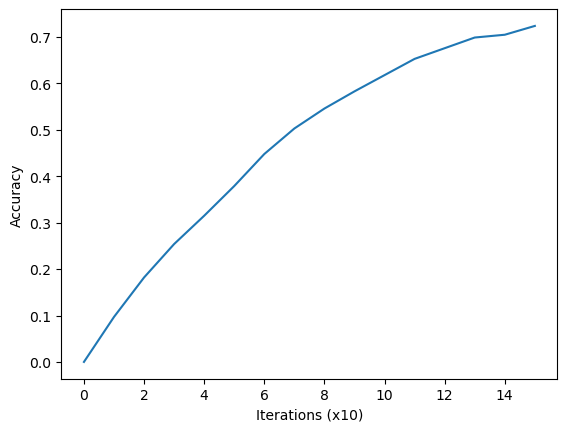

Iteration: 150
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 6 1 9 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 1 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 2 6 9 2 8 7 3 0 2 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 9 2 6 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 0 4 8 6 8 0 5 2 2 4 2 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 6 1 5 3 4 6 9
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 1 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 8 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 7 5 8 7 1 3 9
 6 1 1 1 5

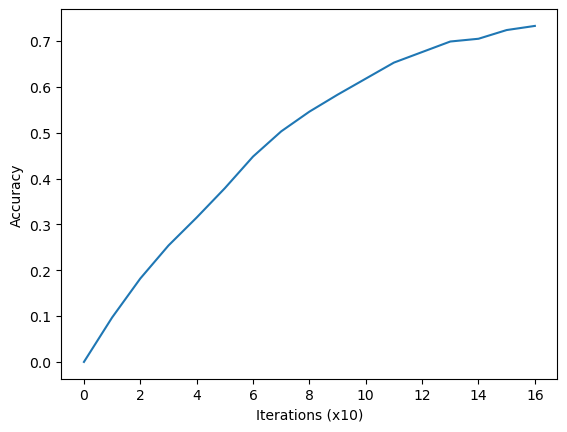

Iteration: 160
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 6 1 7 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 2 6 9 2 8 7 3 0 2 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 9 2 6 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 0 4 8 6 8 0 5 2 2 4 2 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 3 4 6 9
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 9 8 6 4 0 8 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 1 3 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 9 5 8 7 1 3 9
 6 1 1 1 5

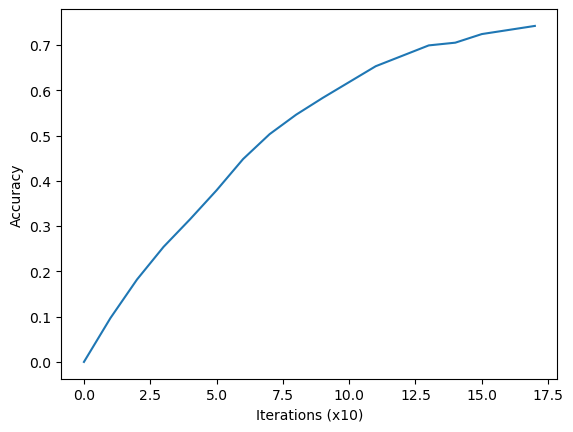

Iteration: 170
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 6 9 0 8 1 6 1 7 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 3 6 9 2 8 7 3 0 6 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 9 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 0 4 8 6 8 0 5 2 2 4 2 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 3 4 6 9
 1 5 7 0 9 9 0 8 9 0 1 8 9 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 3 6 4 0 8 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 3 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 9 8 9 5 8 7 1 3 9
 6 1 1 1 5

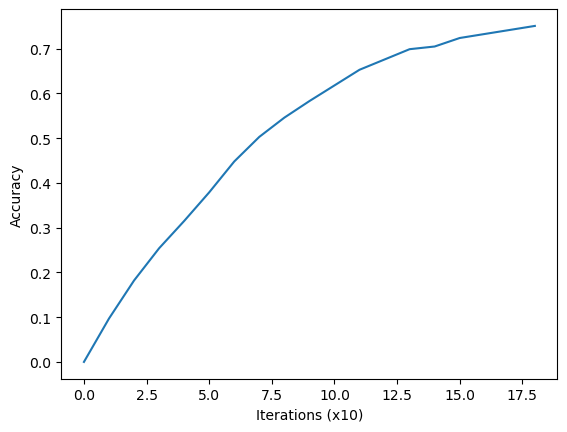

Iteration: 180
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 9 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 3 6 9 2 8 7 3 0 6 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 9 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 4 2 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 3 4 6 9
 1 5 7 0 9 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 3 6 4 0 8 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 3 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 9 5 8 7 1 3 9
 6 1 1 1 5

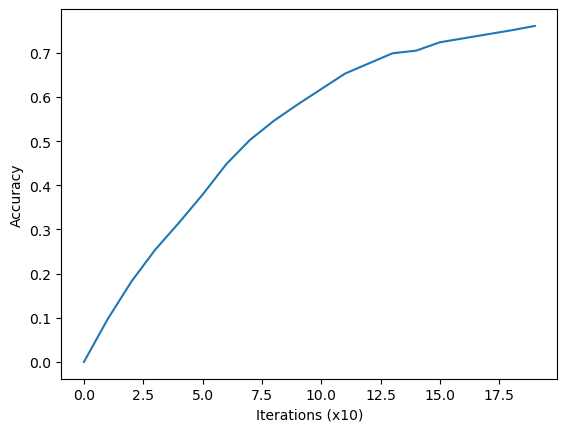

Iteration: 190
[2 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 7 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 3 6 9 2 8 7 3 0 6 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 4 2 9 4 8 5 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 3 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 3 4 6 9
 1 5 7 0 9 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 8 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 2 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 9 5 8 7 1 3 9
 6 1 1 1 5

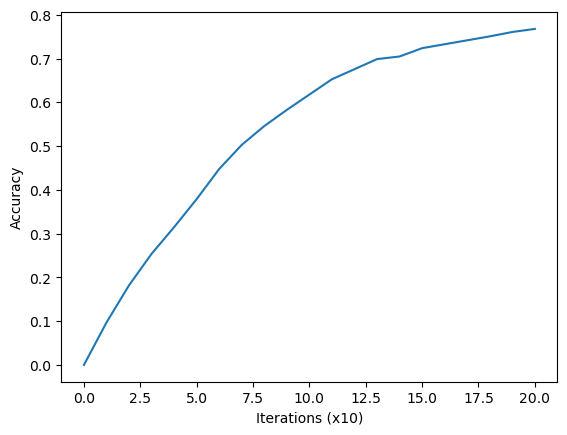

Iteration: 200
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 8 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 2
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 3 6 9 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 4 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 3 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 5 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 8 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 9 5 8 7 1 3 9
 6 1 1 1 5

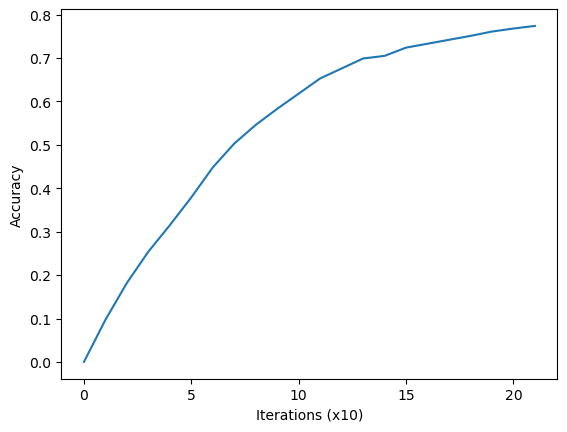

Iteration: 210
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 3 4 0 3 6 9 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 0 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 9 5 8 7 1 3 9
 6 1 1 1 5

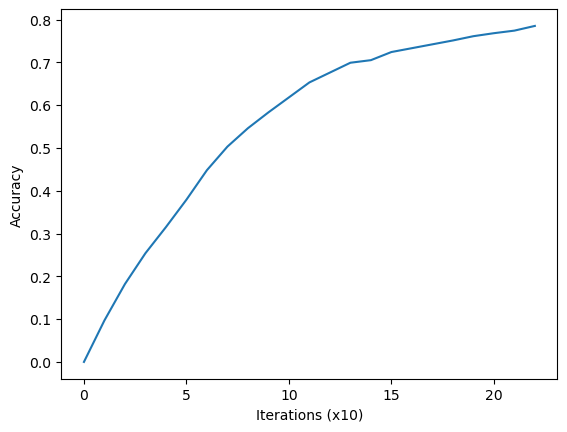

Iteration: 220
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 2 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 9 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 4 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 0 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 8 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 4 2
 2 7 8 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 5

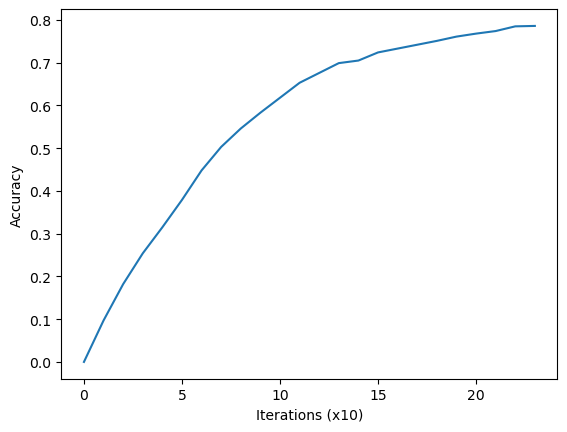

Iteration: 230
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 2 9 6 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 0 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 8 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 3 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 5 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 5

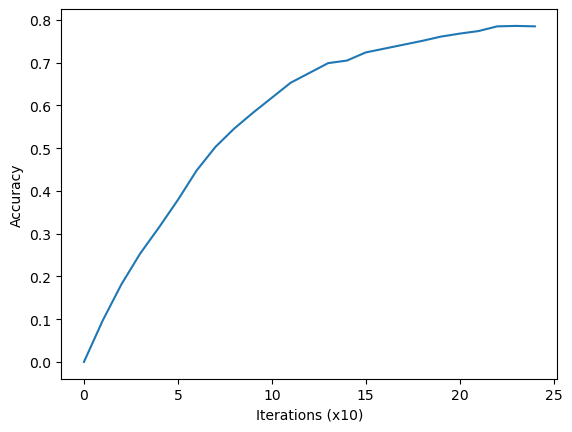

Iteration: 240
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 8 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 8 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 9 1 8 2 8 1 9 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 5

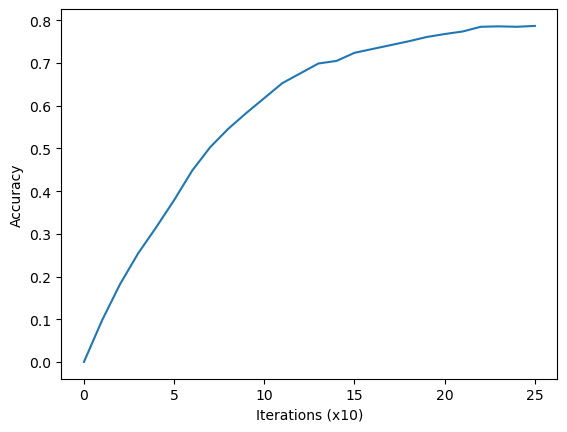

Iteration: 250
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 7 0 4 9 0 8 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 3 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 2 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 9 1 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 9

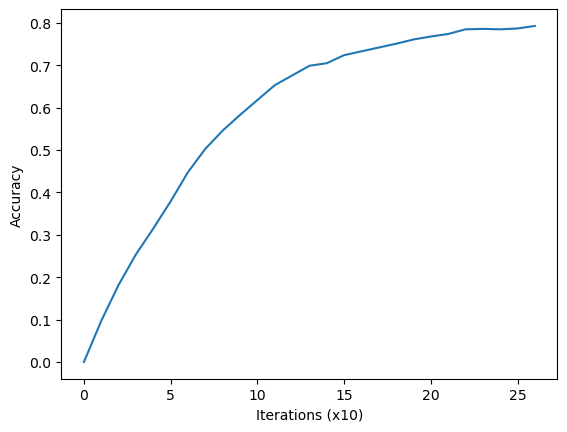

Iteration: 260
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 4 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 8 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 9

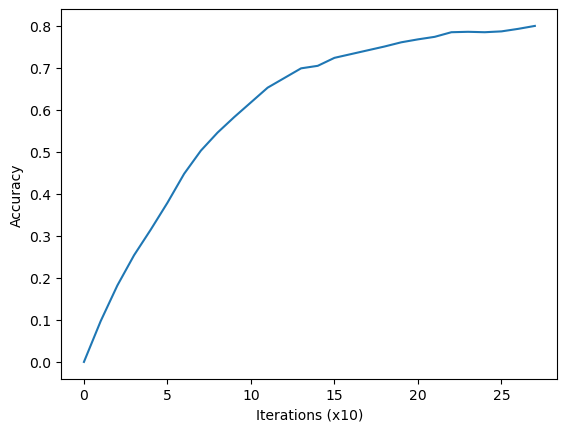

Iteration: 270
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 3 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 8 4 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 9

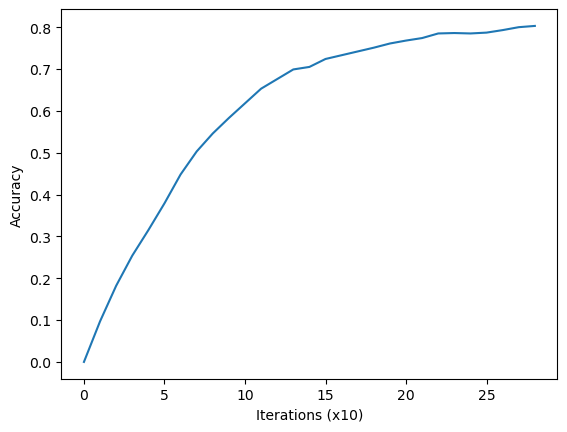

Iteration: 280
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 9 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 5 8 6 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 9 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 4 8 4 5 8 7 1 3 9
 6 1 1 1 9

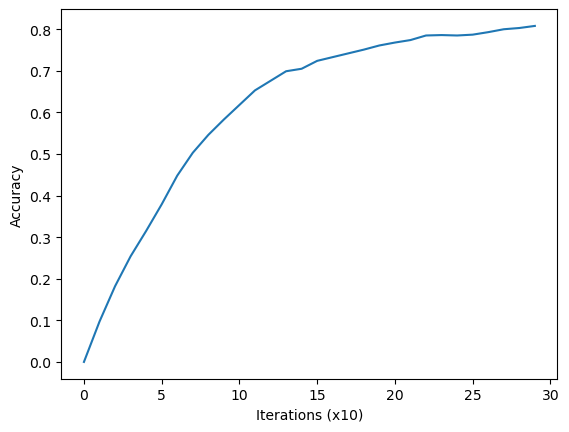

Iteration: 290
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 3 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

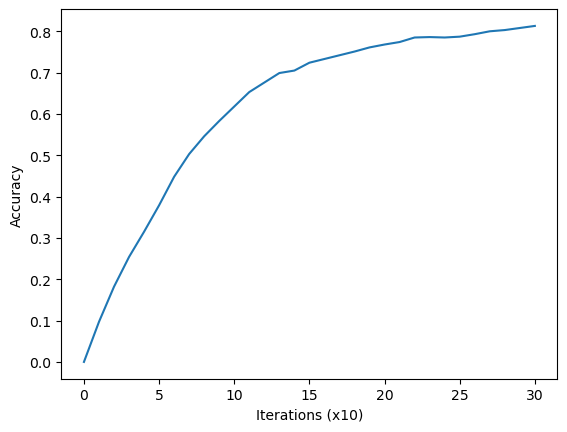

Iteration: 300
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 2 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 6 0 4 2 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 8 2 9 3 7 6 6 7 6 5 3 2 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

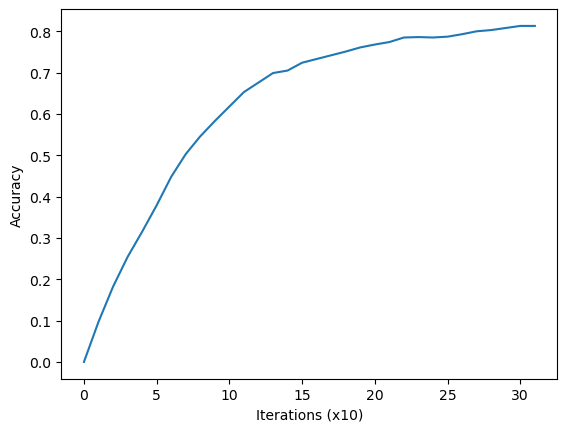

Iteration: 310
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 0 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

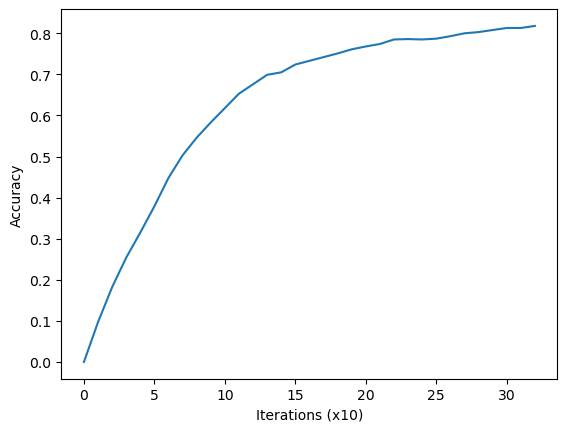

Iteration: 320
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

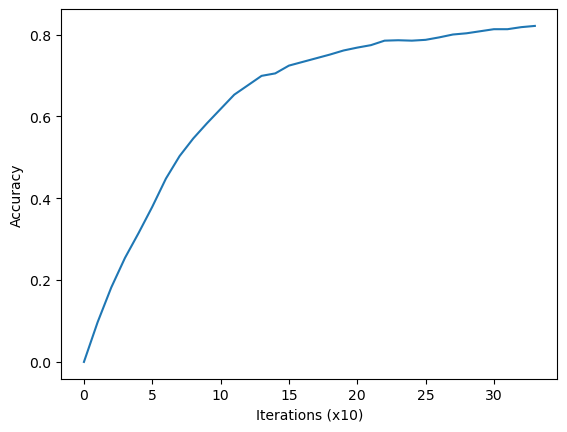

Iteration: 330
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

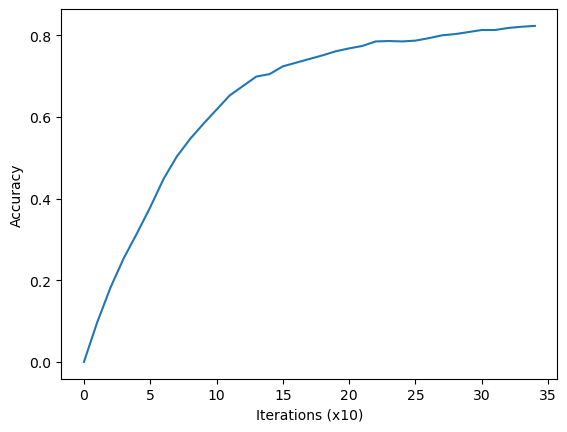

Iteration: 340
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 4 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 0 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 4 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

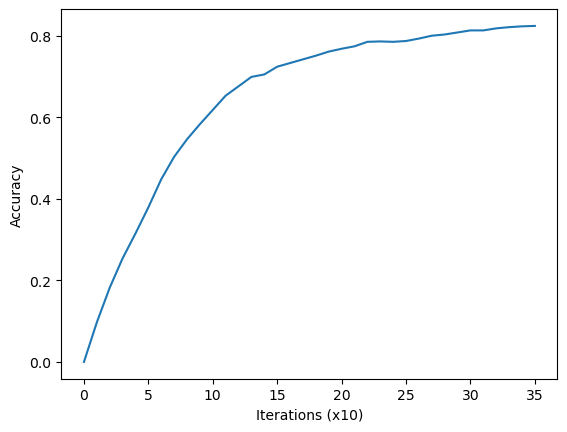

Iteration: 350
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 1 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 8 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

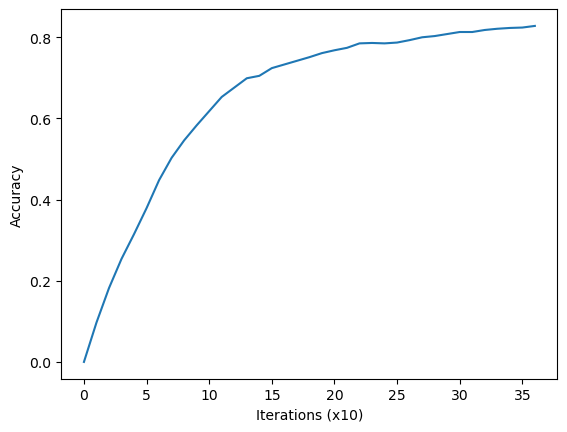

Iteration: 360
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

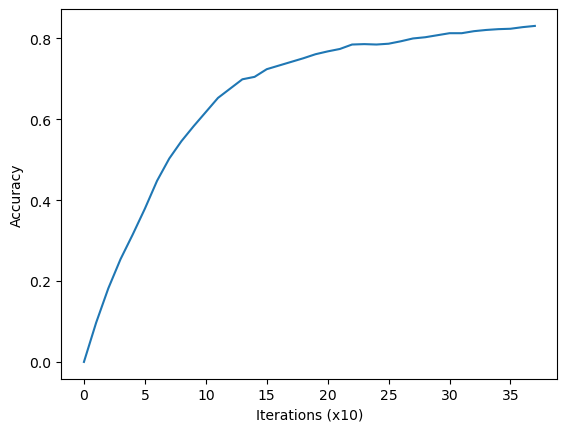

Iteration: 370
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

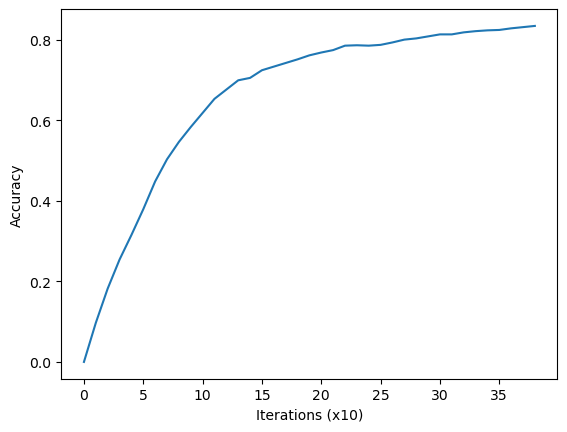

Iteration: 380
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 0 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 6 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

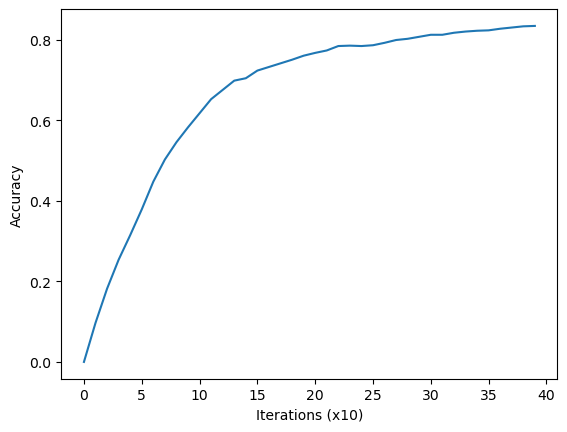

Iteration: 390
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 4 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

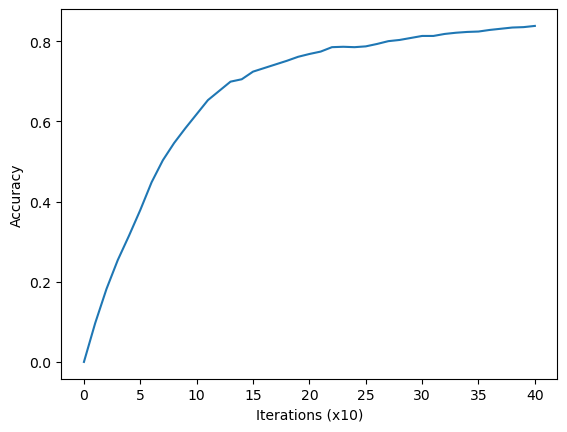

Iteration: 400
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

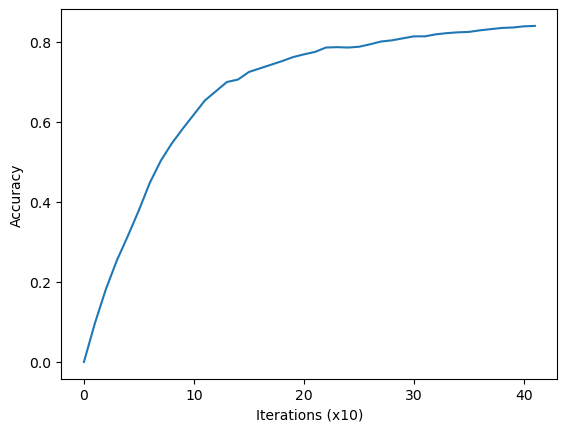

Iteration: 410
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 5 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 3 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

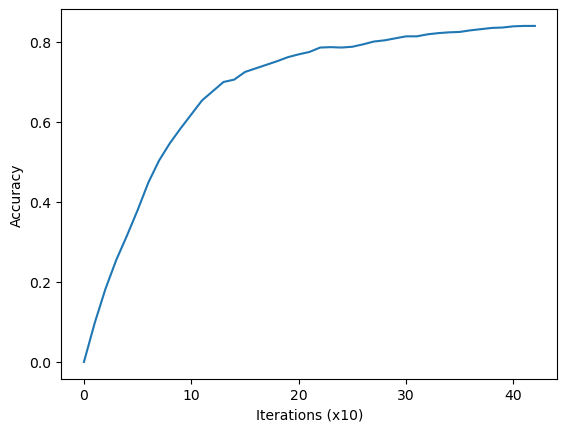

Iteration: 420
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 3 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 6 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

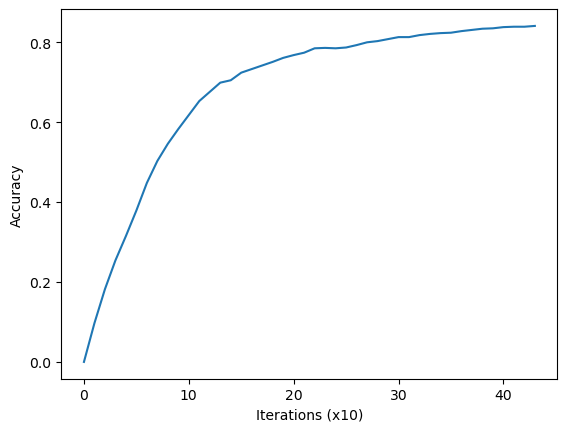

Iteration: 430
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 5 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 3 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 5 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

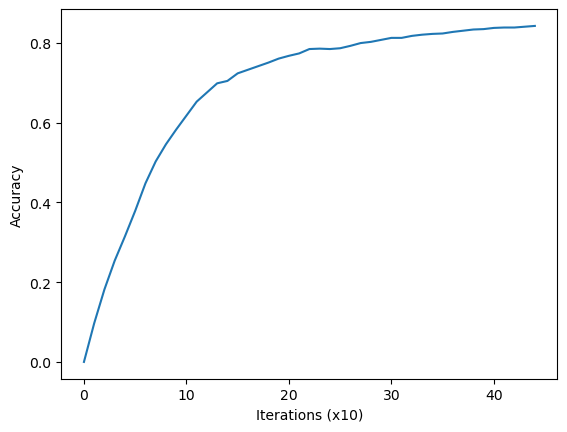

Iteration: 440
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

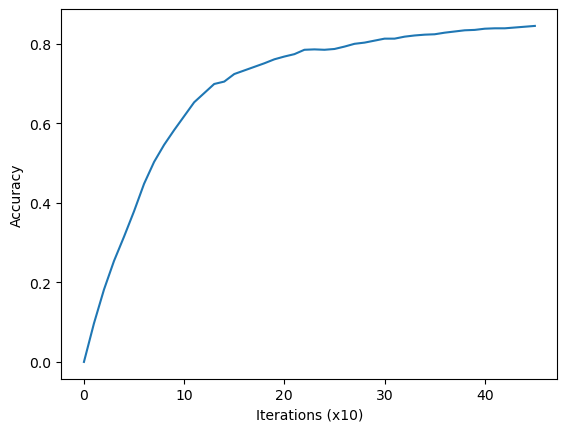

Iteration: 450
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

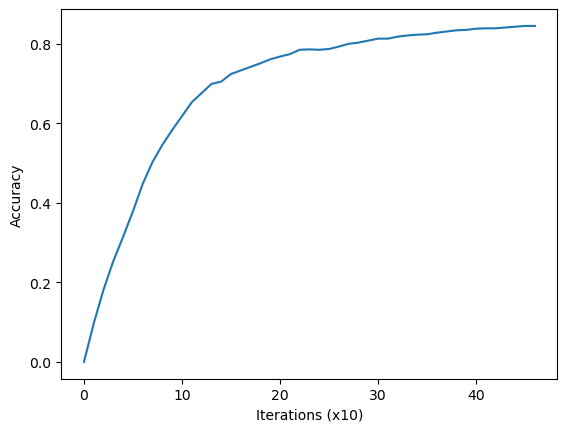

Iteration: 460
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

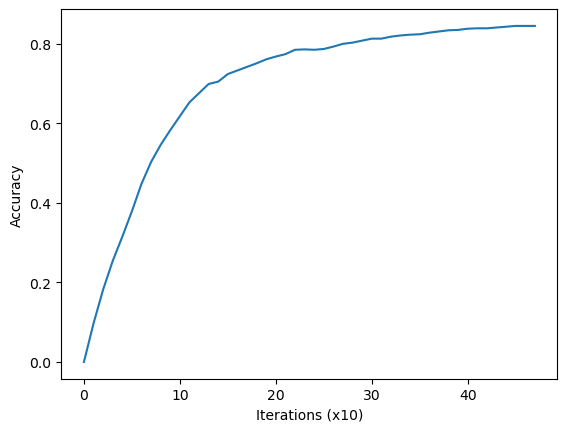

Iteration: 470
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 5 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 9 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

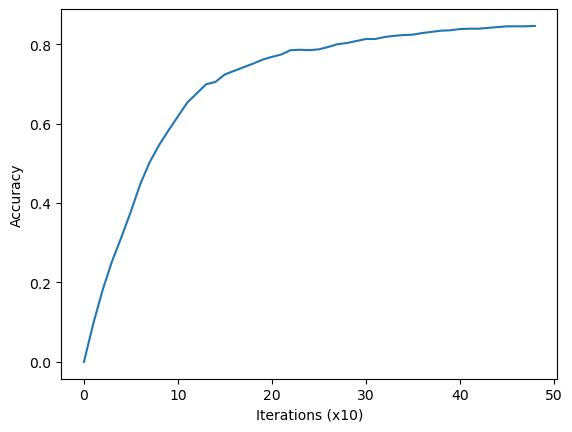

Iteration: 480
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 0 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 8 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

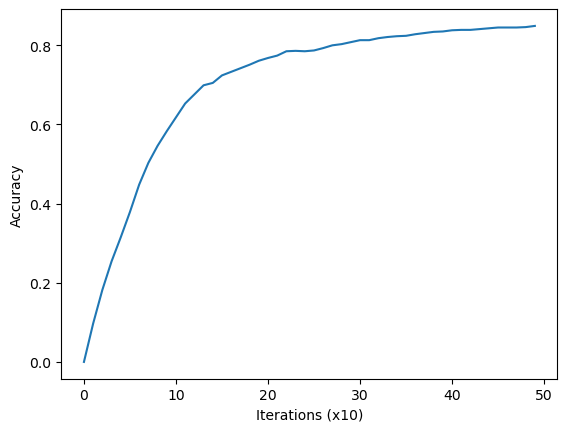

Iteration: 490
[0 1 0 9 1 3 8 2 8 1 1 0 0 6 3 8 5 9 3 7 1 1 5 9 7 1 1 5 9 2 7 3 9 8 5 1 1
 4 2 5 1 8 1 1 4 9 0 1 0 9 0 8 1 6 1 7 4 2 7 8 2 6 1 0 4 2 7 7 7 5 3 0 8 6
 9 7 4 9 6 4 1 9 7 1 0 8 6 2 0 3 1 3 5 9 8 9 9 2 0 1 9 3 5 2 7 2 0 9 4 2 3
 8 4 1 2 7 7 6 6 0 8 3 0 2 5 5 4 0 5 6 4 2 8 7 0 0 8 0 5 5 6 7 3 2 6 7 5 3
 1 3 9 9 0 5 3 5 6 4 8 6 1 7 8 9 1 6 4 5 7 5 3 9 1 5 4 2 4 3 9 4 3 1 1 3 4
 1 1 4 5 1 7 4 7 5 4 8 6 8 0 5 2 2 9 2 9 4 8 9 2 2 8 4 2 2 1 3 9 5 5 7 6 7
 9 2 0 9 0 9 8 1 4 1 3 6 9 4 3 0 9 3 8 3 6 2 8 9 5 1 1 1 2 4 0 1 5 0 4 6 9
 1 5 9 0 9 9 0 3 9 0 1 8 4 5 4 0 3 6 7 2 6 2 1 9 1 0 3 6 5 2 2 3 4 4 3 7 4
 8 6 6 9 2 9 0 1 5 8 4 6 3 3 5 5 5 8 6 9 0 6 3 0 7 3 7 4 5 1 6 4 0 4 6 3 6
 6 3 3 3 7 9 2 2 2 7 2 0 6 1 8 8 7 7 6 4 0 6 7 1 1 8 0 6 1 6 0 2 2 0 5 7 2
 2 7 2 4 0 1 0 6 1 1 1 5 9 8 7 1 2 2 0 7 7 2 5 4 8 9 2 8 1 8 5 9 3 7 9 3 3
 2 1 6 6 2 2 3 0 0 2 5 7 2 4 2 9 3 7 6 6 7 6 0 3 3 2 0 4 5 7 5 0 7 5 3 7 8
 3 1 7 5 9 4 6 0 7 8 5 3 7 9 2 8 1 3 0 8 1 3 6 6 9 4 3 0 5 8 4 5 8 7 1 3 9
 6 1 1 1 9

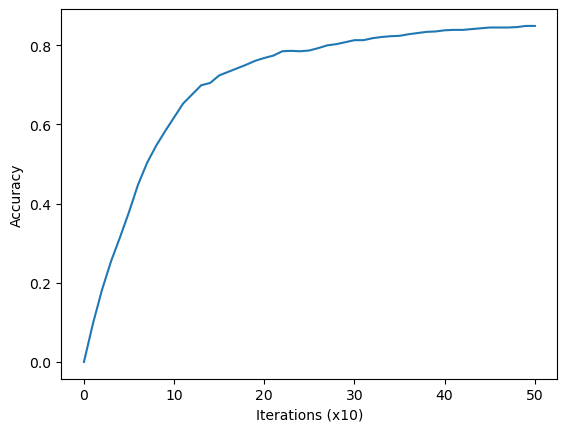

In [27]:
W1, b1, W2, b2 = gradient_descent(values_train, labels_train, 500, 0.1, values_validation, labels_validation)